# Introduction

In this Notebook, we will attempt to train multiple models and choose the best one based on the following matrices:

* Accuracy.
* F-score.
* Receiver operating characteristic (ROC) and Area under the ROC Curve (AUC).
* Confusion Matrix

The models that we are going to fit are the following:

* Bagging Decision Tree
* Random Forest
* XBoost
* CATBoost
* Neural Network
* kNN

The data used for training, testing and validation is cleaned, transformed, encoded using dummy encoder, and scaled as per Phase 2. 
The dataset file is 'Final Data.csv' provided in the Datasets directory in project phase 2 submission. From this data we choose the best features already found in Phase 2 using feature engineering and dimensionality reduction and chose to fit our model on these columns only. The columns are the following:

'Age',
'Annual_Premium',
'Vehicle_Damage_Yes',
'Vintage',
'Policy_Sales_Channel',
'Gender_Male',
'Gender_Female',
'Vehicle_Age_Ordinal'

# Understanding the Data Limitation

The majority of our columns were **categorical**, which is why in Phase 2 we relied heavily on **dummy encoding**. This raised the number of columns we had to **16**. Now, in Phase 3, we are facing another issue with our data: the majority class.

The problem we are trying to solve is a binary classification problem, but seeing as the **ratio of negative response to positive response is 10:1** in our dataset, we had to find a solution.

First, we ran our models on the dataset as is, to make a baseline (so we can see how much our modified datasets improve the results).

Next, we tried cost-sensitive learning (by assigning a higher weight to the positive response).

This method produced marginally better results, not enough to call it a real improvement and certainly not enough to call a good model. Instead, we tried using SMOTE.

This modified our datasets to a new dataset with no majority class. The resulting models were satisfying, but better changes could have been implemented if not for the time constraints (cost-sensitive ensembles, probabilistic predictions, meta-learning…).

Even though the use of SMOTE should eliminate the concept of “minority” and “majority classes, we observed that all our models predicted what was previously the majority class (the negative response) much better. This is what led us to believe that SMOTE was not sophisticated enough to fix our large imbalance issue.


**In addition**, due to the small size of features we used the best features only we faced other problems. The small amount of parameters may cause underfitting for some models and it happened, especially when it comes to neural networks.


# Imports

In [ ]:
import nltk
import keras
import sklearn
import xgboost
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import SGD
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import BaggingClassifier
from tensorflow.python.client import device_lib
from sklearn.tree import DecisionTreeClassifier
from mlxtend.plotting import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import learning_curve,train_test_split,StratifiedKFold, KFold, GridSearchCV,RepeatedStratifiedKFold,cross_val_score
from sklearn.metrics import precision_score,confusion_matrix, accuracy_score,f1_score, roc_auc_score,auc, roc_curve, recall_score,log_loss,classification_report, make_scorer
#reproducibility
SEED=6

# Writing Some Functions for later usage

These functions will help in visualizing the learning curve, ROC, and confusion matrix

In [ ]:
def plot_ROC(model,model_name):
    with tf.device('/gpu:0'):
        Y_score = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(Y_test, Y_score)
    plt.plot(fpr,tpr)
    plt.plot((0,1), ls='dashed',color='black')
    plt.title(str(model_name)+' ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    print ('Area under curve (AUC): ', auc(fpr,tpr))

In [ ]:
def CM_CR(model,model_name):
    classes = ["Response 0", "Response 1"]

    print("results")
    
    with tf.device('/gpu:0'):
        y_pred = model.predict(X_test)
    precision = precision_score(Y_test, y_pred,average='micro') 
    recall = recall_score(Y_test, y_pred,average='micro')
    f1 = f1_score(Y_test, y_pred,average='micro')
    print("-"*90)
    print("Derived Report")
    print("-"*90)
    print("%s%.2f%s"% ("Precision     : ", precision*100, "%"))
    print("%s%.2f%s"% ("Recall        : ", recall*100,    "%"))
    print("%s%.2f%s"% ("F1-Score      : ", f1*100,        "%"))
    print("-"*90)
    print("\n\n")

    CM = confusion_matrix(Y_test, y_pred)

    fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(10,8), hide_ticks=True,cmap=plt.cm.Blues)
    plt.xticks(range(len(classes)), classes, fontsize=12)
    plt.yticks(range(len(classes)), classes, fontsize=12)
    plt.title("Confusion Matrix for: "+ str(model_name)+ "\n", fontsize=20)
    plt.show()


    cls_report_print = classification_report(Y_test, y_pred, target_names=classes)

    cls_report = classification_report(Y_test, y_pred, target_names=classes, output_dict=True)

    print("\n\n")
    print("-"*90)
    print("-"*90)
    print(cls_report_print)
    print("-"*90)

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    with tf.device('/gpu:0'): 
        train_sizes, train_scores, test_scores = learning_curve(
            estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
        train_scores_mean = 1- np.mean(train_scores, axis=1)
        test_scores_mean = 1-np.mean(test_scores, axis=1)
        plt.grid()
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

        plt.show()


# cv = ShuffleSplit(n_splits=5, test_size=0.4, random_state=0)

# Import, split Data and Apply SMOTE

A problem with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary, to overcome this drawback we use SMOTE.

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

In [ ]:
df=pd.read_csv('Final Data.csv')

y=df.Response

In [ ]:
#Getting best features from phase 2
X = df[[
'Age',
'Annual_Premium',
'Vehicle_Damage_Yes',
'Vintage',
'Policy_Sales_Channel',
'Gender_Male',
'Gender_Female',
'Vehicle_Age_Ordinal'
]]

Spliting data into 80% train and 20% test

In [ ]:
X_train,X_test,Y_train,y_test = tts(X,y,test_size= 0.20,random_state=42,shuffle=True)

Applying SMOTE on training set only to avoid data leakage

In [ ]:
X_train, y_train = SMOTE().fit_resample(X_train, Y_train)

Spliting train data into 80% training and 20% validation. 

In [ ]:
xtrain, xval, ytrain, yval = tts(X_train,y_train,test_size=0.2)

# Bagging Decision Tree (BaggingClassifier)

## Experimental Setup

A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

## Hyperparameter tuning

We are performing an exhaustive search over specified parameter values for an estimator. The parameters used are found in sclearn documentation of BaggingClassifier, and we didn't use all parameters cause grid search uses a lot of time to get the best combination of parameters.

Why **n_estimators** ?

Because it's one of the most important parameters in decision trees, it's the number of base estimators in the ensemble.

*We only used this parameter in this grid search cause we already demonstrated that fitting other parameters on other models performed better than on the bagging classifier and because grid search takes a lot of time to run we preferred  investing this time on other models.*  

In [ ]:
n_estimators=[50,100,200]

params =dict(n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

GS_Bagging = GridSearchCV(BaggingClassifier(random_state=SEED),scoring='accuracy', param_grid=params, verbose=1, cv=kfold,n_jobs=-1)
GS_Bagging.fit(X_train, Y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 85.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=6, shuffle=True),
             error_score=nan,
             estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
                                         bootstrap_features=False,
                                         max_features=1.0, max_samples=1.0,
                                         n_estimators=10, n_jobs=None,
                                         oob_score=False, random_state=6,
                                         verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_estimators': [50, 100, 200]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [ ]:
print('Best params',GS_Bagging.best_params_,'yielded',GS_Bagging.best_score_,'accuracy')

Best params {'n_estimators': 200} yielded 0.9074358923545829 accuracy


In [ ]:
BC=BaggingClassifier(random_state=SEED,n_estimators=200)
BC.fit(X_train,Y_train)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=200,
                  n_jobs=None, oob_score=False, random_state=6, verbose=0,
                  warm_start=False)

results
------------------------------------------------------------------------------------------
Derived Report
------------------------------------------------------------------------------------------
Precision     : 84.34%
Recall        : 84.34%
F1-Score      : 84.34%
------------------------------------------------------------------------------------------





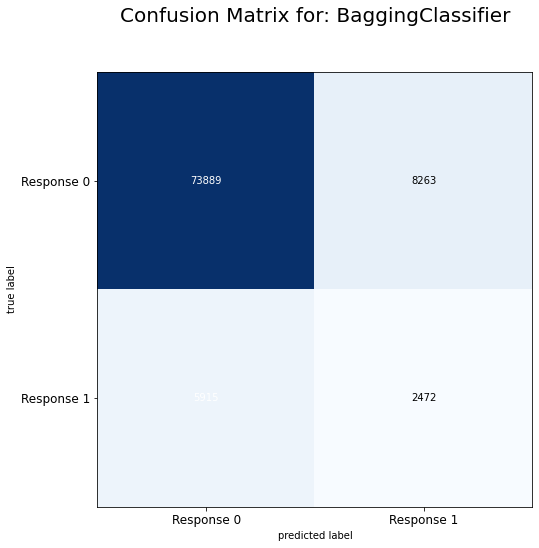




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

  Response 0       0.93      0.90      0.91     82152
  Response 1       0.23      0.29      0.26      8387

    accuracy                           0.84     90539
   macro avg       0.58      0.60      0.59     90539
weighted avg       0.86      0.84      0.85     90539

------------------------------------------------------------------------------------------


In [ ]:
CM_CR(BC,"BaggingClassifier")

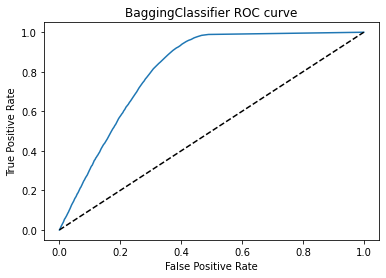

Area under curve (AUC):  0.8104611748774934


In [ ]:
plot_ROC(BC,"BaggingClassifier")

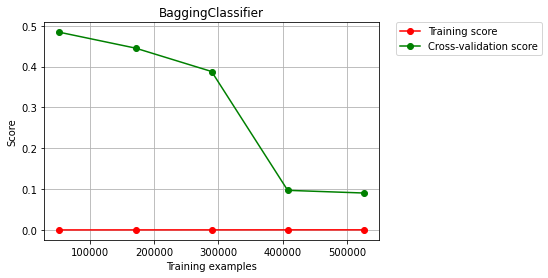

In [ ]:
plot_learning_curve(BC,"BaggingClassifier", X_train, Y_train, cv=None)

## Evaluation

Similar to the bagging classifier trained on all the features we had the same issue of performing really poorly on the minority class.

Using just the best features produced virtually the same results and even very similar learning curves and AUC, this could imply two things:

The model wasn’t overfitting in the first place (using all features), so in reducing it to just the best features we didn’t get better results
The model, using either the best features or all features, isn’t learning enough (as implied by the learning curves using best features and all features), and so it is producing equally sub-par results.
Note: these reasons apply for all “best features” models, since all of them performed really similarly to their counterparts where we used all features.


# Random Forest

## Experimental Setup

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree. 

## Hyperparameter tuning

We are performing an exhaustive search over specified parameter values for an estimator. The parameters used are found in sclearn documentation of  RandomForestClassifier, and we didn't use all parameters cause grid search uses a lot of time to get the best combination of parameters.

### Why these parameters
**Criterion** is the function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.

**n_estimators** is the number of trees in forest

**min_samples_split** is minimum number of samples required to split an internal node

In [ ]:
criterion = ['gini', 'entropy']
n_estimators=[20,40,60]
# max_features=['auto', 'sqrt']
min_samples_leaf=[1,2]


#max_depth=[6,10]
#depth of the tree, might not be useful in our case since our data is huge 
#and we arent suffering from overfitting

params =dict(criterion=criterion,
            n_estimators=n_estimators,
             min_samples_leaf=min_samples_leaf
#            max_features=max_features,
#             max_depth=max_depth
            )

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

GS_RF = GridSearchCV(RandomForestClassifier(random_state=SEED), param_grid=params, verbose=1, cv=kfold,n_jobs=-1)
GS_RF.fit(X_train, Y_train)

In [ ]:
#finding best parameters
print('Best params',GS_RF.best_params_,'yielded',GS_RF.best_score_,'accuracy')

In [ ]:
#fit with best parameters
RF=RandomForestClassifier(criterion='gini',min_samples_leaf=1,n_estimators=60,random_state=SEED,n_jobs=-1)
RF.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=-1,
                       oob_score=False, random_state=6, verbose=0,
                       warm_start=False)

results
------------------------------------------------------------------------------------------
Derived Report
------------------------------------------------------------------------------------------
Precision     : 84.25%
Recall        : 84.25%
F1-Score      : 84.25%
------------------------------------------------------------------------------------------





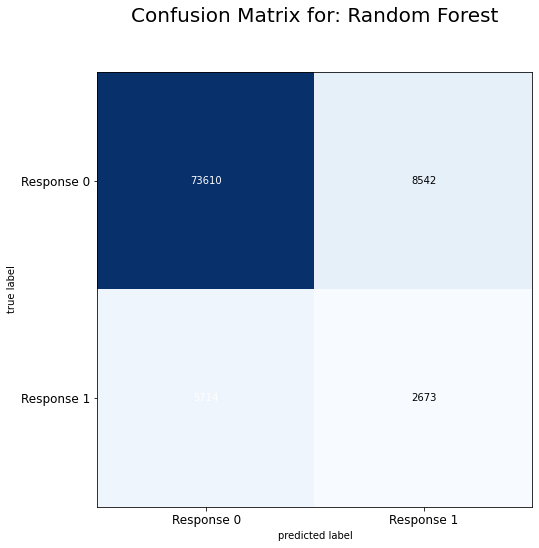




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

  Response 0       0.93      0.90      0.91     82152
  Response 1       0.24      0.32      0.27      8387

    accuracy                           0.84     90539
   macro avg       0.58      0.61      0.59     90539
weighted avg       0.86      0.84      0.85     90539

------------------------------------------------------------------------------------------


In [ ]:
CM_CR(RF,"Random Forest")

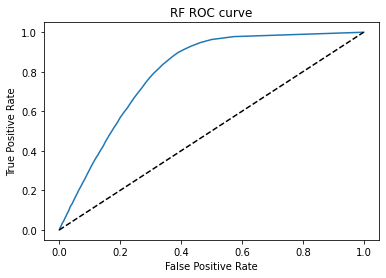

Area under curve (AUC):  0.7986121662499928


In [ ]:
plot_ROC(RF,"RF")

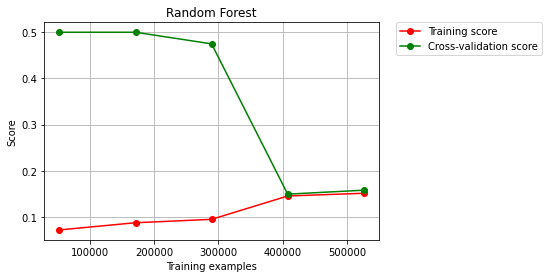

In [ ]:
plot_learning_curve(RF, 'Random Forest', X_train, Y_train, cv=None)

## Evaluation

Comparing between the model fitted on all features and this model we find virtually no difference. If anything, the confusion matrix of all features had slightly better results, but both sub-par and similar. (Same reasons as the decision trees model apply)

# XGBoost

## Experimental Setup

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.

## Hyperparameter tuning

We are performing an exhaustive search over specified parameter values for an estimator. The parameters used are found in sclearn documentation of  RandomForestClassifier, and we didn't use all parameters cause grid search uses a lot of time to get the best combination of parameters.

### kFold Validation

In, we are using Stratified KFold with 10 splits for validation to improve the performance of our model and help the model fit better and to give an unbiased estimate of the skill of the final tuned model when comparing or selecting between final models 

In [ ]:
#L2 regularization term on weights. Increasing this value will make model more conservative.
reg_lambda = [0.8, 1.2]

#L1 regularization term on weights. Increasing this value will make model more conservative.
reg_alpha=[0.8, 1.2]

learning_rate=[0.15,0.3]

#n_estimators=[100,200]

params =dict(reg_lambda=reg_lambda,
            reg_alpha=reg_alpha,
            learning_rate=learning_rate,
#            n_estimators=n_estimators
            )

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

GS_XGB = GridSearchCV(XGBClassifier(random_state=SEED), param_grid=params, verbose=1, cv=kfold,scoring='accuracy',n_jobs=-1)
GS_XGB.fit(X_train, Y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 25.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=6, shuffle=True),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=6, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.15, 0.3], 'reg_alpha': [0.8, 1.2],
                         'reg

In [ ]:
print('Best params',GS_XGB.best_params_,'yielded',GS_XGB.best_score_,'accuracy')

Best params {'learning_rate': 0.3, 'reg_alpha': 0.8, 'reg_lambda': 0.8} yielded 0.8543041101971907 accuracy


In [ ]:
XGB= XGBClassifier(random_state = SEED, max_depth = 8, 
                             n_estimators =200,
                             reg_lambda =0.8, reg_alpha =0.8 , 
                            tree_method ='gpu_hist',
                             objective = 'binary:logistic',
                             learning_rate =0.3 , gamma = 5, colsample_bytree = 0.5, eval_metric = 'auc')

XGB.fit(X_train, Y_train,
                 eval_set = [(X_test, Y_test)],
                 early_stopping_rounds=50,verbose = 1000)

[0]	validation_0-auc:0.766055
Will train until validation_0-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[22]	validation_0-auc:0.830671



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='auc',
              gamma=5, learning_rate=0.3, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=6,
              reg_alpha=0.8, reg_lambda=0.8, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

results
------------------------------------------------------------------------------------------
Derived Report
------------------------------------------------------------------------------------------
Precision     : 77.00%
Recall        : 77.00%
F1-Score      : 77.00%
------------------------------------------------------------------------------------------





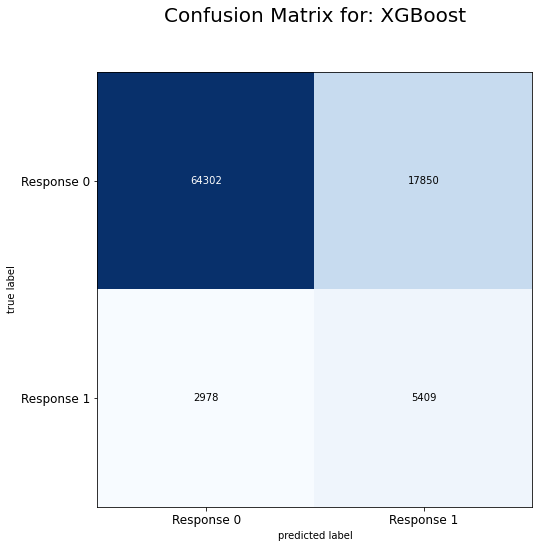




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

  Response 0       0.96      0.78      0.86     82152
  Response 1       0.23      0.64      0.34      8387

    accuracy                           0.77     90539
   macro avg       0.59      0.71      0.60     90539
weighted avg       0.89      0.77      0.81     90539

------------------------------------------------------------------------------------------


In [ ]:
CM_CR(XGB,"XGBoost")

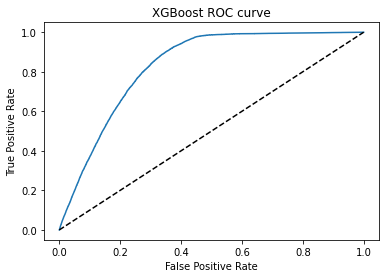

Area under curve (AUC):  0.8306714842595397


In [ ]:
plot_ROC(XGB,"XGBoost")

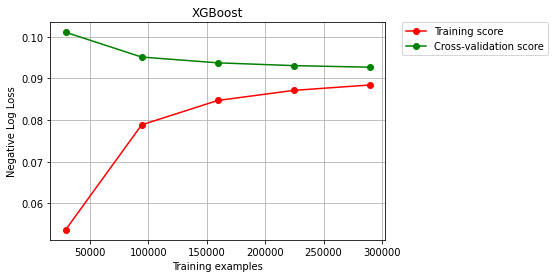

In [ ]:
plot_learning_curve(XGB,"XGBoost", X_train, Y_train, cv=None)

## Evaluation

The XGBoost model using just the best features had a very similar confusion matrix to that of the model using all features. The learning curve, yet again, is very similar to the model using all feature

# CatBoost

## Experimental Setup

Catboost, unlike XGBOOST can handle categorical data. And, seeing as most of our data is categorical.

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
categorical_features=['Vehicle_Age_Ordinal' , 'Policy_Sales_Channel','Gender_Female', 'Gender_Male', 'Vehicle_Damage_Yes']
num_features=['Age','Annual_Premium','Age_times_Annual']

In [ ]:
Cat_model = CatBoostClassifier(iterations = 300, 
                                random_seed = SEED, 
                                task_type = 'GPU',
                                learning_rate=0.15,
                                loss_function='Logloss',
                                eval_metric='Logloss',
                                custom_loss = ['AUC'] )
Cat_model.fit(X_train, Y_train,cat_features = categorical_features, eval_set = (X_test, Y_test), plot = False)

0:	learn: 0.5419337	test: 0.5424013	best: 0.5424013 (0)	total: 53.9ms	remaining: 16.1s
1:	learn: 0.4485038	test: 0.4491454	best: 0.4491454 (1)	total: 105ms	remaining: 15.7s
2:	learn: 0.3886156	test: 0.3892972	best: 0.3892972 (2)	total: 157ms	remaining: 15.6s
3:	learn: 0.3511170	test: 0.3520007	best: 0.3520007 (3)	total: 210ms	remaining: 15.5s
4:	learn: 0.3269361	test: 0.3280111	best: 0.3280111 (4)	total: 268ms	remaining: 15.8s
5:	learn: 0.3107564	test: 0.3120381	best: 0.3120381 (5)	total: 314ms	remaining: 15.4s
6:	learn: 0.3000144	test: 0.3014220	best: 0.3014220 (6)	total: 360ms	remaining: 15.1s
7:	learn: 0.2929017	test: 0.2944388	best: 0.2944388 (7)	total: 405ms	remaining: 14.8s
8:	learn: 0.2880457	test: 0.2896928	best: 0.2896928 (8)	total: 450ms	remaining: 14.5s
9:	learn: 0.2674660	test: 0.2693642	best: 0.2693642 (9)	total: 499ms	remaining: 14.5s
10:	learn: 0.2565144	test: 0.2585713	best: 0.2585713 (10)	total: 542ms	remaining: 14.2s
11:	learn: 0.2494600	test: 0.2515406	best: 0.251540

results
------------------------------------------------------------------------------------------
Derived Report
------------------------------------------------------------------------------------------
Precision     : 78.72%
Recall        : 78.72%
F1-Score      : 78.72%
------------------------------------------------------------------------------------------





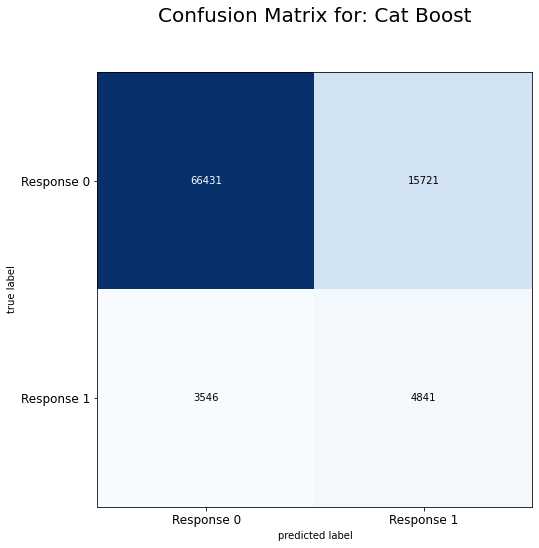




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

  Response 0       0.95      0.81      0.87     82152
  Response 1       0.24      0.58      0.33      8387

    accuracy                           0.79     90539
   macro avg       0.59      0.69      0.60     90539
weighted avg       0.88      0.79      0.82     90539

------------------------------------------------------------------------------------------


In [ ]:
CM_CR(Cat_model,"Cat Boost")

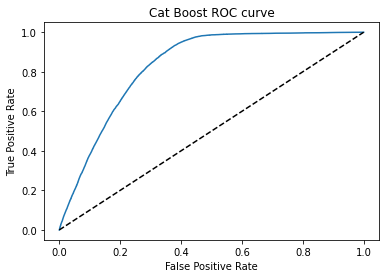

Area under curve (AUC):  0.8328376393913934


In [ ]:
plot_ROC(Cat_model,"Cat Boost")

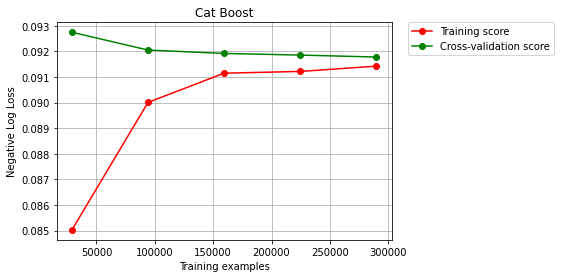

In [ ]:
plot_learning_curve(Cat_model,"Cat Boost", X_train, Y_train, cv=None)

## Evaluation

This model represents the biggest dichotomy yet between a model with all features to model with best features. We mentioned above that the first Catboost model performed just like the other models, without over-predicting the minority class (thus avoiding the 15,000+ false positives the XGBoost produced). However, the Catboost using feature selection went back to what the XGBoost did. It did in fact over-predict, but that produced a slightly better f1 score (0.33 from 0.27), overall nothing major. Again, we would like to note that the model had no issues at all predicting the majority class with precisions and f-1 measures of 0.9+. 


# Neural Network

## Experimental Setup

We will train a neural network on the training data for 25 epochs with mini-batch size as hyperparameter .

The architecture is as follows:
- Multiple hidden layer with units as hyperparameter, 
- One output layer preceded with one dropout layer and one batch normalization layer 
- The activation of the hidden layers is a Relu cause it does not activate all the neurons at the same time
- The activation of the output layer is a Softmax because it converts the scores to a normalized probability distribution, which can be displayed to a user or used as input to other systems.
- The loss function is a binary cross-entropy funtion
- The optimizer of this model is adam because combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems.


## Hyperparameters Tuning

We will tune the hyperparameters of the above architecture using random search by validating on the validation set. 

The hyperparameters that need to be tuned are:
- Learning rates
- Dropout rate
- Number of hidden units
- Mini-batch size
- Learning rate decay
- Number of layers

We will be using random search to find the best parameters cause GridSearch is taking a huge ammount of time and we are going to implement our own random search

In [ ]:
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code cause it doesnt support f1 anymore
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
#The function that build the neural network given the random parameters
import random
def create_model(params):
    model = keras.Sequential()
    model.add(keras.layers.Dense(units = params['units'],activation = 'relu',input_shape = (xtrain.shape[1],))) 
    for i in range(params['layers']):
        model.add(keras.layers.Dense(units = params['units'],activation = 'relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(params['dropout']))
    model.add(keras.layers.Dense(1,activation='softmax'))
    
    opt = keras.optimizers.adam(lr=params['Learning Rate'], decay = params['decay'])                               
    model.compile(optimizer = opt,loss='binary_crossentropy',metrics = ['accuracy',get_f1])
    return model

In [ ]:
#The function that does the randomization given the parameters dictionnary
#It fits models based on the <<num_iterations>> parameter and append these models to a list 
def random_search(params, num_iterations, xtrain, ytrain, xval, yval, epochs):
    models = []
    for i in range(num_iterations):
        print("Sample Number : "+str(i+1))        
        passing_params = {}
        passing_params.update({'layers' : random.choice(params['layers'])})
        passing_params.update({'Learning Rate' :random.choice(params['Learning Rate'])})
        passing_params.update({'units' : random.choice(params['units'])})
        passing_params.update({'batchSize' : random.choice(params['batchSize'])})
        passing_params.update({'decay' : random.choice(params['decay'])})
        passing_params.update({'dropout' : random.choice(params['dropout'])})
        print('Batch Size : '+str(passing_params['batchSize']))
        model = create_model(passing_params)
        h = model.fit(xtrain,ytrain,validation_data=(xval,yval),
                            batch_size=passing_params['batchSize'],epochs=epochs)
        val_acc = h.history['val_accuracy'][-1]
        get_f1 = h.history['get_f1'][-1]
        models.append([str(passing_params),val_acc,get_f1,h,model])
    return models

In [ ]:
#The table of choosen values for parameter tuning
params = { 'Learning Rate': [0.001, 0.25, 0.5, 0.4],
          'dropout' : [0.2,0.1,0.3],
          'batchSize' : [128,256,512,1024],
          'decay': [0.055,0.003, 0.022, 0.001],
          'layers' : [7,10,15],
          'units' : [20,30,40,50]
         }

In [ ]:
#Fitting the model using 15 epochs on 5 randmonized set of paremeters
models = random_search(params,5 ,xtrain, ytrain, xval, yval, 15)

Sample Number : 1
Batch Size : 512
Train on 526086 samples, validate on 131522 samples
Epoch 1/15
526086/526086 [==============================] - 15s 28us/step - loss: 7.6660 - accuracy: 0.5000 - get_f1: 0.6665 - val_loss: 7.6271 - val_accuracy: 0.4998 - val_get_f1: 0.6662
Epoch 2/15
526086/526086 [==============================] - 17s 32us/step - loss: 7.6660 - accuracy: 0.5000 - get_f1: 0.6664 - val_loss: 7.6271 - val_accuracy: 0.4998 - val_get_f1: 0.6662
Epoch 3/15
526086/526086 [==============================] - 18s 34us/step - loss: 7.6660 - accuracy: 0.5000 - get_f1: 0.6664 - val_loss: 7.6271 - val_accuracy: 0.4998 - val_get_f1: 0.6662
Epoch 4/15
526086/526086 [==============================] - 17s 33us/step - loss: 7.6660 - accuracy: 0.5000 - get_f1: 0.6664 - val_loss: 7.6271 - val_accuracy: 0.4998 - val_get_f1: 0.6662
Epoch 5/15
526086/526086 [==============================] - 18s 34us/step - loss: 7.6660 - accuracy: 0.5000 - get_f1: 0.6664 - val_loss: 7.6271 - val_accuracy: 0

In [ ]:
#This function is used to get the best model given the list of models generated earlier
def getBest(models):
    best_model_params = models[0][0]
    maxAcc = models[0][1]*100
    f = models[0][2]
    h = models[0][3]
    best_model = models[0][4]
    for model in models:
        if model[1]>maxAcc:
            maxAcc = model[1]*100
            best_model_params = model[0]
            f = model[2]
            h = model[3]
            best_model = model[4]
    return best_model_params, maxAcc, f, h, best_model
parameters, accuracy, Fmeasure, history, model = getBest(models)
print("The highest accuracy is",accuracy,"and it corresponds to these following hyperparameters\n")
print(parameters)
print("It's F-measure is", Fmeasure)


The highest accuracy is 49.98403191566467 and it corresponds to these following hyperparameters

{'layers': 15, 'Learning Rate': 0.5, 'units': 50, 'batchSize': 512, 'decay': 0.001, 'dropout': 0.1}
It's F-measure is 0.6664199


## Evaluating the model using Accuracy and Fmeasure

The neural network presented very low accuracy and Fmeasure. The low accuracy means that you are doing underfitting (high bias) and the low Fmeasure indicates both poor precision and poor recall. This  poor performance is due to poor training and overfitted and underfitted classes in the data because of SMOTE. We could conclude clearly that SMOTE after all isn't that good to deal with imbalanced data when it comes to neural networks

## Visualize Model Training History

Below is the plot of accuracy on the training and validation datasets over training epochs.

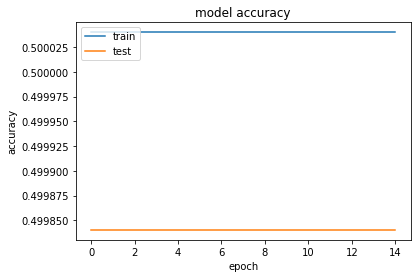

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

From the plot of accuracy, we can see that the model must be trained differently and more epochs will not increase the performance since it didn't change during the whole training. This means the optimizer has found a local minimum for the loss. This may be an undesirable minimum. One common local minimum is to always predict the class with the most number of data points. It could also mean that the optimizer isn't fit for the data.

We tried **many** combinations and many different architectures but nothing helped to get the best results. This might be because of the undersampling of the majority class and the oversampling of the minority class that happened when we used SMOTE.

Below is the plot of loss on the training and validation datasets over training epochs.

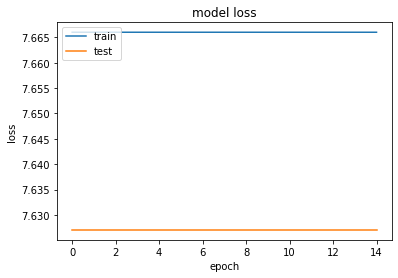

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

From the plot of loss, we can see that both validation and training loss are very high but very similar.
Higher loss is the worse(bad prediction) for any model. The loss is calculated on training and validation and its interpretation is how well the model is doing for these two sets.
If the model's prediction is perfect, the loss is zero; otherwise, the loss is greater.
The loss in our model is very high indicating that the model isn't well-performing.
From the other side, we see that the validation and training loss are very similar and that the validation loss is lower than the training loss and this is the result of data leakage because of SMOTE.

## Evaluating the model using ROC and AUC

AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. By analogy, Higher the AUC, better the model is at distinguishing between patients with disease and no disease.

To make the plot looks more meaningful, let's train another binary classifier and compare it with our Keras classifier later in the same plot.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=10)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

Now, let's plot the ROC for the two classifiers.

In [ ]:
y_pred = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)

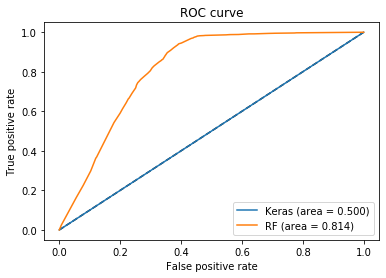

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

With AUC=0.5, then the classifier is not able to distinguish between Positive and Negative class points. Meaning either the classifier is predicting random class or constant class for all the data points.

## Comparing with the previouse Neural Network

Since the model operated very badly on the first place, reducing the dataset to the important features only increased the accuracy and Fmeasure for a very minimal fraction. Both models using all features and best features are not helpful, their performance and evaluation are the same.

# KNN

KNN algorithm is one of the simplest classification algorithm and it is one of the most used learning algorithms.KNN is a non-parametric, lazy learning algorithm. Its purpose is to use a database in which the data points are separated into several classes to predict the classification of a new sample point. The KNN algorithm works to classify new data based on its proximity to K-neighbors (training data). So if the new data is surrounded by training data that has Class 1, it can be concluded that the new data is included in Class.

##Experimental Setup

Parameters:

n_neighbors

Number of neighbors. We set the value from 3 to 10. We will choose later the most appropriate on the values passed to fit method.

weights{‘uniform’, ‘distance’}

We used both weights, which is kept for the gridSearch to choose which one is most appropriate on the values passed to fit method, chosen by the randomSearch.

algorithm

we use the auto algo which will attempt to decide the most appropriate algorithm based on the values passed to fit method.

Leaf_size

This can affect the speed of the construction and query, as well as the memory required to store the tree. From 30,60 & 90, we will get the most appropriate value on the values passed to fit method, by the randomSearch.

p

Power parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2. We set the parameter for both values, we will get the most appropriate value on the values passed to fit method, by the randomSearch.

n_jobs

We used -1 value to use all processes while fitting.

In [ ]:
#Grid Table for kNN
kNN_parameters = {
    "n_neighbors" : np.arange(3, 10),
    "weights"     : ['uniform', 'distance'],    
    "leaf_size"   : [30,60,90],
    "p"           : [1,2]
}
n_jobs = -1

We pass the Knn Parameters, after choosing our model (KNeighborsClassifier), then we run our random search using the parameters chosen before, with 3 random iterations and cv = 3. We used these small values inorder to finish the random search and fitting algo in the fastest time possible.

##Hyper Parameters Tuning

In machine learning, hyperparameter tuning is the problem of choosing a set of optimal hyperparameters for a learning algorithm. A hyperparameter is a parameter whose value is used to control the learning process. By contrast, the values of other parameters are learned.

In [ ]:
knn = KNeighborsClassifier()
clf = RandomizedSearchCV(knn,kNN_parameters,n_iter=3,n_jobs=-1,cv=3)
kNN = clf.fit(X_train,Y_train)

After finishing the fitting algorithm, we save the values in kNN variable, and then we interpret the result by printing them to the screen. We print the best estimator, best score, and best parameters in our to determine what are the parameters chosen by the random search funtion.

In [ ]:
print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", kNN.best_estimator_)
print("\n The best score across ALL searched params:\n", kNN.best_score_)
print("\n The best parameters across ALL searched params:\n", kNN.best_params_)

 Results from Random Search 

 The best estimator across ALL searched params:
 KNeighborsClassifier(n_neighbors=4, weights='distance')

 The best score across ALL searched params:
 0.8812864206242246

 The best parameters across ALL searched params:
 {'weights': 'distance', 'p': 2, 'n_neighbors': 4, 'leaf_size': 30}


Interpreting the results

1) We can determine that the hyper parameters chosen after the tuning process on the data with the selected features were {'weights': 'distance', 'p': 2, 'n_neighbors': 4, 'leaf_size': 30}. We can see that the parameters didn't change accoring to the random search function, even by chosing the best features.

2) The best score across all search params chosen by the random search funtion on our new data (after choosing the best features), was 88% similar to the accuracy on the whole initial data .

3)We got the best estimator parameters n_neighbors = 4 and weights= "distance". The rest parameters weren't mentioned because they are chosen by default in the funtion. 

##Evaluating using Confusion Matrix

We use the predict function in the model class to predict the values gained by the fitting function with the Input_testing data.

We use the accuracy_score function to get the accuracy of our model.

In [ ]:
knn_predict = kNN.predict(X_test)
knn_accuracy = accuracy_score(Y_test, knn_predict)

Accuracy is:  0.790532256817504 

KNN Reports
               precision    recall  f1-score   support

           0       0.94      0.82      0.88     82266
           1       0.21      0.46      0.29      8273

    accuracy                           0.79     90539
   macro avg       0.57      0.64      0.58     90539
weighted avg       0.87      0.79      0.82     90539



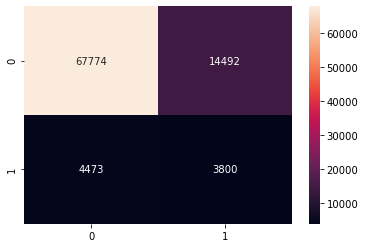

In [ ]:
import seaborn as sns

print('Accuracy is: ',knn_accuracy, '\n')
cm = confusion_matrix(Y_test,knn_predict)
sns.heatmap(cm,annot=True,fmt="d")

print('KNN Reports\n',classification_report(Y_test, knn_predict))


The results here (on the feature selected data) are similar to the one in our whole data confusion matrix. We can determine that the F-scores for response 0 is high where the values is 0.88 indicating perfect precision and recall. For the second value we can determine that the F-score value for the response 1 is low which is 0.29 indicating low precision and recall. But we can notice that the accuracy of our model is 0.79 which means it has a good accuracy.

##Evaluating using ROC

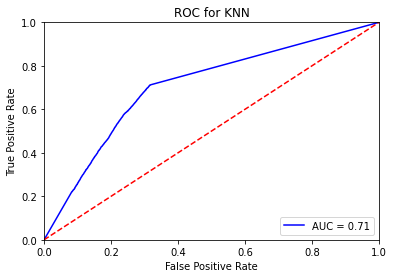

In [ ]:
import sklearn.metrics as metrics

probs = kNN.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

#  plt
import matplotlib.pyplot as plt
plt.title('ROC for KNN')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In general, we use the following rule of thumb: And the AUC value as determined from the graph, is 0.71 this value means our descrimination is acceptable.

# Conclusion: Overall Evaluation of Feature Selection

In addition to the Interpretation of the result gathered from all models and mentioned above: 

After interpreting the results we got after applying the model to the feature selected dataset above, we can say that the overall performance wasn’t deteriorating performance. In some models, we found out that the performance improved, but the majority had no change either improving or declining in performance, which is considered as stagnating performance.

# Best Model
In our case since all the models performed relatively the same, the choice was not super clear. But, if we had to choose we’d pick the CatBoost model trained on the data set with feature selection. Our decision is based on objective analysis of the different scores the model got (precision, recall, f1-score). 

